In [ ]:
!pip install pyscf

In [ ]:
!pip install qiskit

In [3]:
import numpy as np
import pylab
import copy
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD #ansatz
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType # for mapping

In [8]:
molecule = 'H .0 .0 -{0}; Li .0 .0 {0}' 
distances = np.arange(0.5,4.25,0.25)
vqe_energies = []
hf_energies = [] # initial guess from Hartree-Fock
exact_energies = []

In [ ]:
for i,d in enumerate(distances):
  print('step',i)

  # set up experiment

  driver = PySCFDriver(molecule.format(d/2), basis = 'sto3g')
  qmolecule = driver.run()
  operator = Hamiltonian(qubit_mapping=QubitMappingType.PARITY,
                         two_qubit_reduction=True, 
                         freeze_core=True,
                         orbital_reduction=[-3,-2])
  qubit_op, aux_ops = operator.run(qmolecule)

  # exact classical result

  exact_result = NumPyMinimumEigensolver(qubit_op, aux_operators=aux_ops).run()
  exact_result = operator.process_algorithm_result(exact_result)

  # VQE
  optimizer = SLSQP(maxiter=1000)
  initial_state = HartreeFock(operator.molecule_info['num_orbitals'],
                              operator.molecule_info['num_particles'],
                              qubit_mapping=operator._qubit_mapping,
                              two_qubit_reduction=operator._two_qubit_reduction)
  
  var_form = UCCSD(num_orbitals=operator.molecule_info['num_orbitals'],
                   num_particles=operator.molecule_info['num_particles'],
                   initial_state=initial_state,
                   qubit_mapping=operator._qubit_mapping,
                   two_qubit_reduction=operator._two_qubit_reduction)
  
  algo=VQE(qubit_op, var_form, optimizer, aux_operators=aux_ops)

  vqe_result=algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
  vqe_result=operator.process_algorithm_result(vqe_result)

  exact_energies.append(exact_result.energy)
  vqe_energies.append(vqe_result.energy)
  hf_energies.append(vqe_result.hartree_fock_energy)

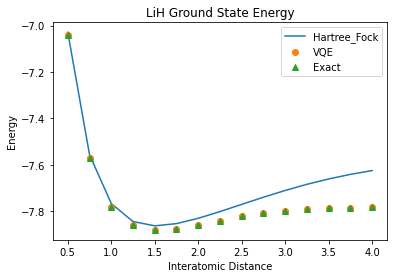

In [19]:
 pylab.plot(distances,hf_energies, label='Hartree_Fock')
 pylab.plot(distances, vqe_energies, 'o', label='VQE')
 pylab.plot(distances, exact_energies, '^', label='Exact')

 pylab.xlabel('Interatomic Distance')
 pylab.ylabel('Energy')
 pylab.title('LiH Ground State Energy')
 pylab.legend()